In [115]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

In [116]:
def gen_binomial_tree(S0, T, u, d, N):
    """Returns the future stock values from time 0 to time T in N timesteps given the parameters.

    Args:
        S0 (float): Initial price of the stock.
        T (float): Maturity date in years. (simply the final time in our calculation horizon)
        u (float): 0 < u < 1, stock return multiplier for a timestep given it is an up state.
        d (float): 0 < d < 1, stock return multiplier for a timestep given it is a down state.
        N (int): Number of timesteps in T.

    Returns:
        S (np.array): Shape (N, 2**N) array, columns are N timesteps 0 to T, rows are different combination of states.
    """
    S0_vector = np.full((2**N, 1), S0)
    combinations = np.array(list(itertools.product([u, d], repeat=N)))
    S = np.full((2**N, N), S0)
    # print(S.shape)
    S = np.hstack((S0_vector, S))
    
    for j in range(1, S.shape[1]):
        S[:, j] = S[:, j-1] * combinations[:, j-1]
    
    return S

def plot_binomial_tree(binom_tree):
    fig, axs = plt.subplots()
    axs.set_title("Probable $S$ over $N$ timesteps")
    for i in range(binom_tree.shape[0]):
        axs.plot(binom_tree[i, :])
    fig.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


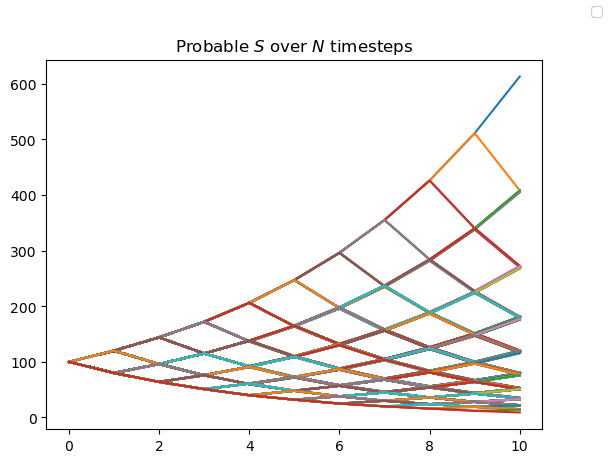

In [117]:
binom_tree = gen_binomial_tree(100, 1, 1.2, 0.8, 10)
plot_binomial_tree(binom_tree)

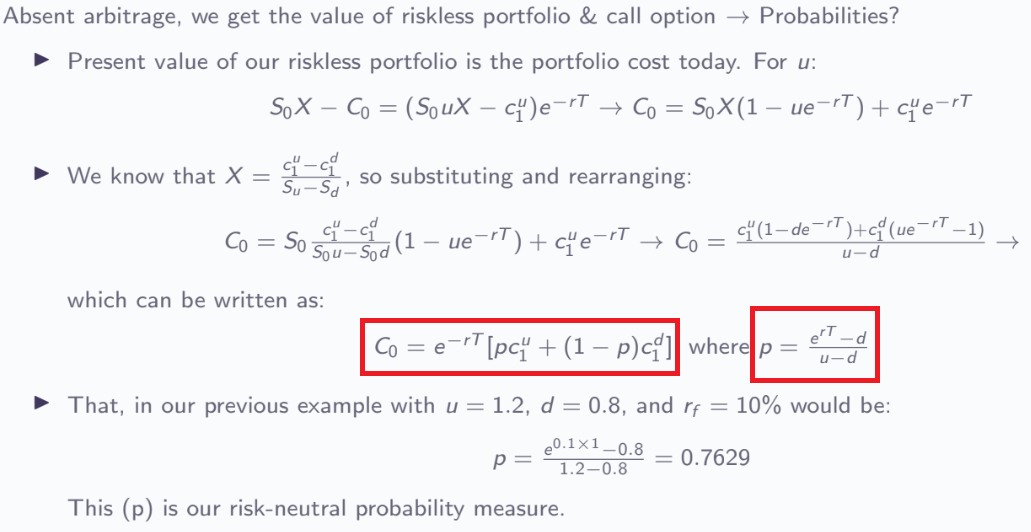

In [118]:
def binomial_call_full(S_ini, K, T, r, u, d, N):
    dt = T / N  # Define time step
    p = (np.exp(r * dt) - d) / (u - d)  # Risk neutral probs
    C = np.zeros([N + 1, N + 1])  # Call prices
    S = np.zeros([N + 1, N + 1])  # Underlying price
    for i in range(0, N + 1):
        C[N, i] = max(S_ini * (u ** (i)) * (d ** (N - i)) - K, 0)
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
    return C[0, 0], C, S

def binomial_put_full(S_ini, K, T, r, u, d, N):
    dt = T / N  # Define time step
    p = (np.exp(r * dt) - d) / (u - d)  # Risk neutral probs
    P = np.zeros([N + 1, N + 1])  # Call prices
    S = np.zeros([N + 1, N + 1])  # Underlying price
    for i in range(0, N + 1):
        P[N, i] = max(K - (S_ini * (u ** (i)) * (d ** (N - i))), 0)
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            P[j, i] = np.exp(-r * dt) * (p * P[j + 1, i + 1] + (1 - p) * P[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
    return P[0, 0], P, S

put_price, P, S = binomial_put_full(36, 36, 50, 0.01, 1.1, 0.7, 50)
print("Underlying Price Evolution:\n", S)
print("Put Option Payoff:\n", P)
print("Price at t=0 for Put option is$", "{:.2f}".format(put_price))

Underlying Price Evolution:
 [[3.60000000e+01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.52000000e+01 3.96000000e+01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.76400000e+01 2.77200000e+01 4.35600000e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.32132126e-06 2.07636197e-06 3.26285453e-06 ... 3.49262042e+03
  0.00000000e+00 0.00000000e+00]
 [9.24924879e-07 1.45345338e-06 2.28399817e-06 ... 2.44483429e+03
  3.84188246e+03 0.00000000e+00]
 [6.47447415e-07 1.01741737e-06 1.59879872e-06 ... 1.71138400e+03
  2.68931772e+03 4.22607070e+03]]
Put Option Payoff:
 [[ 7.5822903   0.          0.         ...  0.          0.
   0.        ]
 [ 9.54336876  7.11166527  0.         ...  0.          0.
   0.        ]
 [11.63290642  9.06090302  6.63837335 ...  0.          0.
   0.        ]
 ...
 [35.28715092 35.28715016 35.28714898 ...  0.          0.
   0.        ]
 [35.64179309 35.64179256 35.64179173 ...  0.         

We already know that in order to satisfy absence of arbitrage conditions, the relationship between the price of the put and the call options must be:

$C_0 + Ke^{-rT} = S_0 + P_0$

Let's check whether this is the case for t=0:

In [119]:
def call_option_delta(S_ini, K, T, r, sigma, N):
    dt = T / N  # Define time step
    u = np.exp(sigma * np.sqrt(dt))  # Define u
    d = np.exp(-sigma * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    C = np.zeros([N + 1, N + 1])  # call prices
    S = np.zeros([N + 1, N + 1])  # underlying price
    Delta = np.zeros([N, N])  # delta
    print("p =", p)
    for i in range(0, N + 1):
        C[N, i] = max(S_ini * (u ** (i)) * (d ** (N - i)) - K, 0)
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
            Delta[j, i] = (C[j + 1, i + 1] - C[j + 1, i]) / (
                S[j + 1, i + 1] - S[j + 1, i]
            )
    return C[0, 0], C, S, Delta

In [120]:
call_price, C, S, delta = call_option_delta(80, 90, 1, 0.1, 0.2, 1000)
print(call_price)

p = 0.506324903181645
5.737490246264138


In [121]:
call_option_delta(80, 100, 1, 0.1, 0.2, 10)

p = 0.5635944828596942


(2.717952465942887,
 array([[ 2.71795247,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 1.13250428,  3.9940725 ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.33531932,  1.76997995,  5.78746721,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.05100836,  0.56144802,  2.73733966,  8.25246206,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.09141502,  0.93541839,  4.18142602, 11.55192873,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.16383013,  1.5495594 ,  6.29391146,
         15.82934208,  0.        ,  0.        ,  0.

## 3. Introducing Risk-Neutral Probabilities and backward induction of Call Option Value

For the final part of this notebook, let's work with the risk-neutral probabilities. Once we have the probabilities, we can, by backward induction, calculate the value of the Call Option (given its future payoffs and the associated probabilities) at each node.

Importantly, once we know the risk-neutral probabilities, the value of the Call Option at each node will depend on the expected payoff in the two potential future scenarios (up or down movements), discounted at risk-free. That is:

$C_{t}= e^{-rdt}[p c_{t+1}^u + (1-p) c_{t+1}^d]$

where $dt$ is the discounted period from one node to the next (**time-step**), and $c_{t+1}^u$ and $c_{t+1}^d$ are the **values of the Call option in the next period**. We will therefore have to start from the last period (maturity) and work backwards, hence the term backward induction.

Note that we use $dt$ here because we are assuming there are a **bunch of periods (steps) in the tree from the initial date until maturity of the option**. Under the 1-step case, we can calculate risk-neutral probabilities as we did in the videos, because $dt=T/N = 1/1 = 1 = T$:

$p=\frac{e^{rT}-d}{u-d}$

Once we consider a different $dt$, we just need to modify $p$ accordingly:

$p=\frac{e^{rdt}-d}{u-d}$

$C_0 + Ke^{-rT} = S_0 + P_0$

# FUNCTIONS

In [122]:
def binomial_call_full(S_ini, K, T, r, u, d, N):
    dt = T / N  # Define time step
    p = (np.exp(r * dt) - d) / (u - d)  # Risk neutral probs
    C = np.zeros([N + 1, N + 1])  # Call prices
    S = np.zeros([N + 1, N + 1])  # Underlying price
    for i in range(0, N + 1):
        C[N, i] = max(S_ini * (u ** (i)) * (d ** (N - i)) - K, 0)
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
    return C[0, 0], C, S

def binomial_put_full(S_ini, K, T, r, u, d, N):
    dt = T / N  # Define time step
    p = (np.exp(r * dt) - d) / (u - d)  # Risk neutral probs
    P = np.zeros([N + 1, N + 1])  # Call prices
    S = np.zeros([N + 1, N + 1])  # Underlying price
    for i in range(0, N + 1):
        P[N, i] = max(K - (S_ini * (u ** (i)) * (d ** (N - i))), 0)
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            P[j, i] = np.exp(-r * dt) * (p * P[j + 1, i + 1] + (1 - p) * P[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
    return P[0, 0], P, S

def call_option_delta(S_ini, K, T, r, sigma, N):
    dt = T / N  # Define time step
    u = np.exp(sigma * np.sqrt(dt))  # Define u
    d = np.exp(-sigma * np.sqrt(dt))  # Define d
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    C = np.zeros([N + 1, N + 1])  # call prices
    S = np.zeros([N + 1, N + 1])  # underlying price
    Delta = np.zeros([N, N])  # delta
    print("p =", p)
    for i in range(0, N + 1):
        C[N, i] = max(S_ini * (u ** (i)) * (d ** (N - i)) - K, 0)
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
            Delta[j, i] = (C[j + 1, i + 1] - C[j + 1, i]) / (
                S[j + 1, i + 1] - S[j + 1, i]
            )
    return C[0, 0], C, S, Delta

def call_option_delta_2(S_ini, K, T, r, u, d, N):
    dt = T / N  # Define time step
    p = (np.exp(r * dt) - d) / (u - d)  # risk neutral probs
    C = np.zeros([N + 1, N + 1])  # call prices
    S = np.zeros([N + 1, N + 1])  # underlying price
    Delta = np.zeros([N, N])  # delta
    print("p =", p)
    for i in range(0, N + 1):
        C[N, i] = max(S_ini * (u ** (i)) * (d ** (N - i)) - K, 0)
        S[N, i] = S_ini * (u ** (i)) * (d ** (N - i))
    for j in range(N - 1, -1, -1):
        for i in range(0, j + 1):
            C[j, i] = np.exp(-r * dt) * (p * C[j + 1, i + 1] + (1 - p) * C[j + 1, i])
            S[j, i] = S_ini * (u ** (i)) * (d ** (j - i))
            Delta[j, i] = (C[j + 1, i + 1] - C[j + 1, i]) / (
                S[j + 1, i + 1] - S[j + 1, i]
            )
    return C[0, 0], C, S, Delta

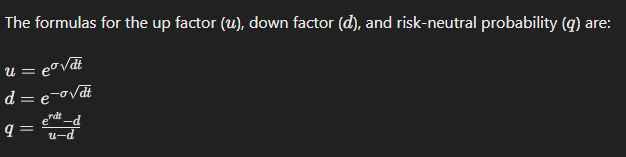

In [123]:
binomial_call_full(100, 90, 4, 0, 1.2, 0.8, 4)

(20.205000000000005,
 array([[ 20.205,   0.   ,   0.   ,   0.   ,   0.   ],
        [  6.84 ,  33.57 ,   0.   ,   0.   ,   0.   ],
        [  0.54 ,  13.14 ,  54.   ,   0.   ,   0.   ],
        [  0.   ,   1.08 ,  25.2  ,  82.8  ,   0.   ],
        [  0.   ,   0.   ,   2.16 ,  48.24 , 117.36 ]]),
 array([[100.  ,   0.  ,   0.  ,   0.  ,   0.  ],
        [ 80.  , 120.  ,   0.  ,   0.  ,   0.  ],
        [ 64.  ,  96.  , 144.  ,   0.  ,   0.  ],
        [ 51.2 ,  76.8 , 115.2 , 172.8 ,   0.  ],
        [ 40.96,  61.44,  92.16, 138.24, 207.36]]))

In [124]:
binomial_call_full(100, 90, 10, 0.1, 1.2, 0.8, 10)

(67.25952259187693,
 array([[ 67.25952259,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ],
        [ 44.39642777,  83.63586874,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ],
        [ 26.03783314,  56.22132224, 103.68404618,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ],
        [ 12.23220542,  33.9171689 ,  70.90234638, 128.1636954 ,
           0.        ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ],
        [  3.49626333,  16.63305163,  43.96359439,  89.04733575,
         157.9863467 ,   0.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ],
        [  0.        ,   5.06466157,  22.52071991,  56.68723384,
     

In [125]:
callprice, C, S, Delta = call_option_delta_2(100, 90, 10, 0, 1.2, 0.8, 10)
Delta

p = 0.5


array([[0.68136669, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.53623571, 0.77812069, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.36566897, 0.64994686, 0.86356991, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.1945407 , 0.47975449, 0.76340844, 0.93034422, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.06161862, 0.28315541, 0.61082055, 0.8651337 , 0.9738179 ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.10269771, 0.40346055, 0.74906055, 0.9425158 ,
        0.99468597, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.17116284, 0.55832568, 0.87621712,
        0.98671492, 1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [126]:
callprice, C, S, Delta = call_option_delta_2(100, 90, 2, 0, 1.1, 0.8, 2)
Delta

p = 0.6666666666666664


array([[0.68888889, 0.        ],
       [0.        , 0.93939394]])

In [127]:
binomial_put_full(36, 31, 50, 0.01, 1.2, 0.8, 50)

(6.90477558995802,
 array([[ 6.90477559,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 7.91195463,  6.12612431,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 8.97219153,  7.10459876,  5.35852849, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [30.38535605, 30.38495463, 30.38435251, ...,  0.        ,
          0.        ,  0.        ],
        [30.69090258, 30.69058145, 30.69009976, ...,  0.        ,
          0.        ,  0.        ],
        [30.99948619, 30.99922929, 30.99884393, ...,  0.        ,
          0.        ,  0.        ]]),
 array([[3.60000000e+01, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.88000000e+01, 4.32000000e+01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.30400000e+01, 3.45600000e+01, 5.18400000e+01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e

In [128]:
call_price, C, S, Delta = call_option_delta_2(100, 90, 10, 0, 1.2, 0.8, 10)
Delta

p = 0.5


array([[0.68136669, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.53623571, 0.77812069, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.36566897, 0.64994686, 0.86356991, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.1945407 , 0.47975449, 0.76340844, 0.93034422, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.06161862, 0.28315541, 0.61082055, 0.8651337 , 0.9738179 ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.10269771, 0.40346055, 0.74906055, 0.9425158 ,
        0.99468597, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.17116284, 0.55832568, 0.87621712,
        0.98671492, 1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [129]:
binomial_call_full(100, 60, 3, 0, 1.1, 0.8, 3)

(40.32592592592593,
 array([[40.32592593,  0.        ,  0.        ,  0.        ],
        [20.97777778, 50.        ,  0.        ,  0.        ],
        [ 6.93333333, 28.        , 61.        ,  0.        ],
        [ 0.        , 10.4       , 36.8       , 73.1       ]]),
 array([[100. ,   0. ,   0. ,   0. ],
        [ 80. , 110. ,   0. ,   0. ],
        [ 64. ,  88. , 121. ,   0. ],
        [ 51.2,  70.4,  96.8, 133.1]]))

In [130]:
q = (np.exp(0.1*1) - 0.8) / (1.2 - 0.8)

r = 0.1
T = 1

P = np.exp(-r*T)*(q*0 + (1-q)*20)
P

4.290245082157568

In [131]:
call_option_delta_2(100, 74, 2, 0, 1.2, 0.8, 2)

p = 0.5


(28.5,
 array([[28.5,  0. ,  0. ],
        [11. , 46. ,  0. ],
        [ 0. , 22. , 70. ]]),
 array([[100.,   0.,   0.],
        [ 80., 120.,   0.],
        [ 64.,  96., 144.]]),
 array([[0.875 , 0.    ],
        [0.6875, 1.    ]]))

In [132]:
putprice, P, S = binomial_put_full(100, 90, 5, 0, 1.2, 0.8, 5)
S

array([[100.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ],
       [ 80.   , 120.   ,   0.   ,   0.   ,   0.   ,   0.   ],
       [ 64.   ,  96.   , 144.   ,   0.   ,   0.   ,   0.   ],
       [ 51.2  ,  76.8  , 115.2  , 172.8  ,   0.   ,   0.   ],
       [ 40.96 ,  61.44 ,  92.16 , 138.24 , 207.36 ,   0.   ],
       [ 32.768,  49.152,  73.728, 110.592, 165.888, 248.832]])

In [133]:
np.log(85/90) / (-2)

0.02857920691997432

In [134]:
callprice, C, S = binomial_call_full(100, 80, 4, 0, 1.1, 0.8, 4)
S

array([[100.  ,   0.  ,   0.  ,   0.  ,   0.  ],
       [ 80.  , 110.  ,   0.  ,   0.  ,   0.  ],
       [ 64.  ,  88.  , 121.  ,   0.  ,   0.  ],
       [ 51.2 ,  70.4 ,  96.8 , 133.1 ,   0.  ],
       [ 40.96,  56.32,  77.44, 106.48, 146.41]])

In [135]:
sigma = 0.3
r = 0.1
dt = 0.01
sigma = 0.3

u = np.exp(sigma*np.sqrt(dt))
d = np.exp(-sigma*np.sqrt(dt))

p = (np.exp(r*dt) - d) / (u - d)
p

0.5091730642400417

In [138]:
callprice, C, S, delta = call_option_delta_2(100, 90, 2, 0, 1.2, 0.8, 2)
delta

p = 0.5


array([[0.675 , 0.    ],
       [0.1875, 1.    ]])

In [139]:
6/32

0.1875

In [141]:
np.convolve((1, 2, 3), (4, 5, 6))

array([ 4, 13, 28, 27, 18])